<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [5]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Reinforciya


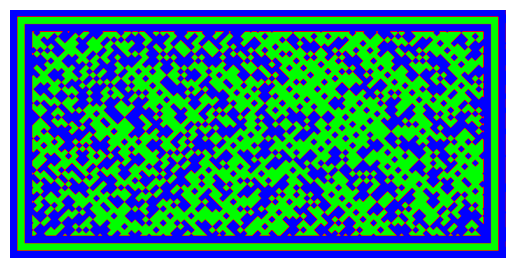

In [6]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [7]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [8]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [10]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [11]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [12]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

  5%|▌         | 1/20 [00:10<03:15, 10.29s/it]

EPOCH: 01/20 LOSS: 1.0411 ACC: 0.4348  VAL-LOSS: 0.8437 VAL-ACC: 0.6025  TEST-LOSS: 0.8702 TEST-ACC: 0.5380 


 10%|█         | 2/20 [00:20<03:08, 10.49s/it]

EPOCH: 02/20 LOSS: 0.7335 ACC: 0.6673  VAL-LOSS: 0.4927 VAL-ACC: 0.7985  TEST-LOSS: 0.5143 TEST-ACC: 0.7840 


 15%|█▌        | 3/20 [00:31<03:01, 10.66s/it]

EPOCH: 03/20 LOSS: 0.4637 ACC: 0.8069  VAL-LOSS: 0.3092 VAL-ACC: 0.8810  TEST-LOSS: 0.3098 TEST-ACC: 0.8800 


 20%|██        | 4/20 [00:42<02:53, 10.85s/it]

EPOCH: 04/20 LOSS: 0.3053 ACC: 0.8733  VAL-LOSS: 0.1697 VAL-ACC: 0.9375  TEST-LOSS: 0.1494 TEST-ACC: 0.9500 


 25%|██▌       | 5/20 [00:53<02:42, 10.84s/it]

EPOCH: 05/20 LOSS: 0.2090 ACC: 0.9171  VAL-LOSS: 0.1502 VAL-ACC: 0.9425  TEST-LOSS: 0.1476 TEST-ACC: 0.9540 


 30%|███       | 6/20 [01:05<02:33, 10.99s/it]

EPOCH: 06/20 LOSS: 0.1744 ACC: 0.9324  VAL-LOSS: 0.0952 VAL-ACC: 0.9690  TEST-LOSS: 0.1085 TEST-ACC: 0.9600 


 35%|███▌      | 7/20 [01:15<02:21, 10.90s/it]

EPOCH: 07/20 LOSS: 0.1339 ACC: 0.9485  VAL-LOSS: 0.1079 VAL-ACC: 0.9560  TEST-LOSS: 0.0862 TEST-ACC: 0.9620 


 40%|████      | 8/20 [01:26<02:10, 10.84s/it]

EPOCH: 08/20 LOSS: 0.1179 ACC: 0.9551  VAL-LOSS: 0.0971 VAL-ACC: 0.9620  TEST-LOSS: 0.1212 TEST-ACC: 0.9420 


 45%|████▌     | 9/20 [01:37<01:58, 10.77s/it]

EPOCH: 09/20 LOSS: 0.1114 ACC: 0.9580  VAL-LOSS: 0.0652 VAL-ACC: 0.9735  TEST-LOSS: 0.0519 TEST-ACC: 0.9820 


 50%|█████     | 10/20 [01:47<01:47, 10.73s/it]

EPOCH: 10/20 LOSS: 0.1150 ACC: 0.9579  VAL-LOSS: 0.0541 VAL-ACC: 0.9785  TEST-LOSS: 0.0395 TEST-ACC: 0.9900 


 55%|█████▌    | 11/20 [01:58<01:36, 10.71s/it]

EPOCH: 11/20 LOSS: 0.0711 ACC: 0.9741  VAL-LOSS: 0.0368 VAL-ACC: 0.9875  TEST-LOSS: 0.0431 TEST-ACC: 0.9840 


 60%|██████    | 12/20 [02:08<01:25, 10.68s/it]

EPOCH: 12/20 LOSS: 0.0747 ACC: 0.9729  VAL-LOSS: 0.0407 VAL-ACC: 0.9835  TEST-LOSS: 0.0396 TEST-ACC: 0.9880 


 65%|██████▌   | 13/20 [02:19<01:14, 10.67s/it]

EPOCH: 13/20 LOSS: 0.0678 ACC: 0.9760  VAL-LOSS: 0.0529 VAL-ACC: 0.9765  TEST-LOSS: 0.0558 TEST-ACC: 0.9720 


 70%|███████   | 14/20 [02:30<01:03, 10.65s/it]

EPOCH: 14/20 LOSS: 0.0745 ACC: 0.9728  VAL-LOSS: 0.0305 VAL-ACC: 0.9940  TEST-LOSS: 0.0306 TEST-ACC: 0.9920 


 75%|███████▌  | 15/20 [02:40<00:53, 10.66s/it]

EPOCH: 15/20 LOSS: 0.0616 ACC: 0.9781  VAL-LOSS: 0.0537 VAL-ACC: 0.9810  TEST-LOSS: 0.0465 TEST-ACC: 0.9860 


 80%|████████  | 16/20 [02:51<00:42, 10.66s/it]

EPOCH: 16/20 LOSS: 0.0550 ACC: 0.9812  VAL-LOSS: 0.0414 VAL-ACC: 0.9850  TEST-LOSS: 0.0233 TEST-ACC: 0.9920 


 85%|████████▌ | 17/20 [03:02<00:31, 10.67s/it]

EPOCH: 17/20 LOSS: 0.0475 ACC: 0.9831  VAL-LOSS: 0.0287 VAL-ACC: 0.9905  TEST-LOSS: 0.0158 TEST-ACC: 0.9960 


 90%|█████████ | 18/20 [03:12<00:21, 10.68s/it]

EPOCH: 18/20 LOSS: 0.0480 ACC: 0.9833  VAL-LOSS: 0.0303 VAL-ACC: 0.9880  TEST-LOSS: 0.0207 TEST-ACC: 0.9920 


 95%|█████████▌| 19/20 [03:23<00:10, 10.74s/it]

EPOCH: 19/20 LOSS: 0.0401 ACC: 0.9849  VAL-LOSS: 0.0299 VAL-ACC: 0.9880  TEST-LOSS: 0.0182 TEST-ACC: 0.9940 


100%|██████████| 20/20 [03:34<00:00, 10.74s/it]

EPOCH: 20/20 LOSS: 0.0418 ACC: 0.9837  VAL-LOSS: 0.0271 VAL-ACC: 0.9885  TEST-LOSS: 0.0267 TEST-ACC: 0.9920 


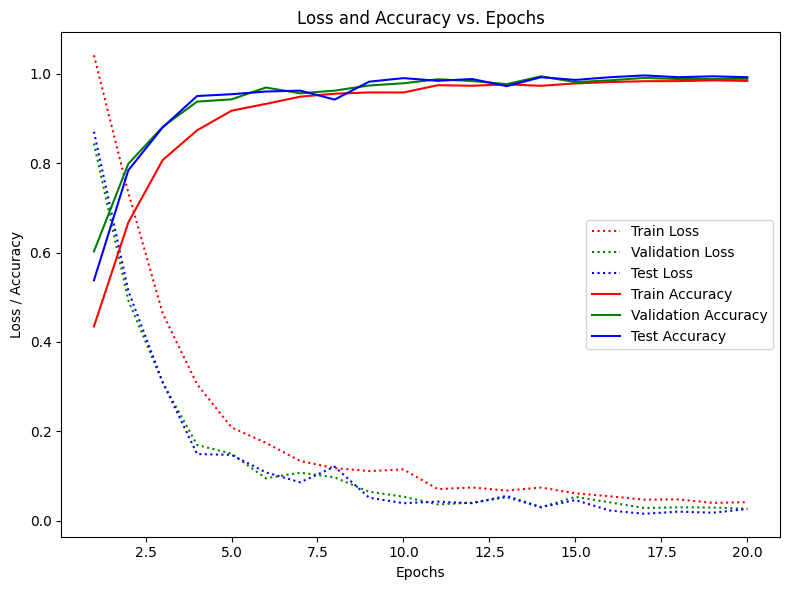

In [13]:
from torch import optim

lr = 0.06
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

  5%|▌         | 1/20 [00:09<02:54,  9.17s/it]

EPOCH: 01/20 LOSS: 1.0837 ACC: 0.3912  VAL-LOSS: 0.9567 VAL-ACC: 0.5345  TEST-LOSS: 0.9409 TEST-ACC: 0.5420 


 10%|█         | 2/20 [00:18<02:45,  9.17s/it]

EPOCH: 02/20 LOSS: 0.8773 ACC: 0.5744  VAL-LOSS: 0.6943 VAL-ACC: 0.6695  TEST-LOSS: 0.7322 TEST-ACC: 0.6680 


 15%|█▌        | 3/20 [00:27<02:35,  9.13s/it]

EPOCH: 03/20 LOSS: 0.6395 ACC: 0.7105  VAL-LOSS: 0.4423 VAL-ACC: 0.8150  TEST-LOSS: 0.4707 TEST-ACC: 0.7920 


 20%|██        | 4/20 [00:37<02:30,  9.39s/it]

EPOCH: 04/20 LOSS: 0.4095 ACC: 0.8267  VAL-LOSS: 0.2562 VAL-ACC: 0.8950  TEST-LOSS: 0.2597 TEST-ACC: 0.9020 


 25%|██▌       | 5/20 [00:46<02:19,  9.30s/it]

EPOCH: 05/20 LOSS: 0.3203 ACC: 0.8653  VAL-LOSS: 0.1847 VAL-ACC: 0.9300  TEST-LOSS: 0.1678 TEST-ACC: 0.9400 


 30%|███       | 6/20 [00:54<02:05,  8.99s/it]

EPOCH: 06/20 LOSS: 0.2690 ACC: 0.8888  VAL-LOSS: 0.1977 VAL-ACC: 0.9120  TEST-LOSS: 0.1846 TEST-ACC: 0.9160 


 35%|███▌      | 7/20 [01:03<01:54,  8.77s/it]

EPOCH: 07/20 LOSS: 0.2263 ACC: 0.9107  VAL-LOSS: 0.1547 VAL-ACC: 0.9410  TEST-LOSS: 0.1282 TEST-ACC: 0.9420 


 40%|████      | 8/20 [01:11<01:43,  8.65s/it]

EPOCH: 08/20 LOSS: 0.2101 ACC: 0.9200  VAL-LOSS: 0.1207 VAL-ACC: 0.9545  TEST-LOSS: 0.1135 TEST-ACC: 0.9480 


 45%|████▌     | 9/20 [01:20<01:35,  8.69s/it]

EPOCH: 09/20 LOSS: 0.1927 ACC: 0.9223  VAL-LOSS: 0.0903 VAL-ACC: 0.9730  TEST-LOSS: 0.0891 TEST-ACC: 0.9700 


 50%|█████     | 10/20 [01:28<01:25,  8.56s/it]

EPOCH: 10/20 LOSS: 0.1757 ACC: 0.9287  VAL-LOSS: 0.1006 VAL-ACC: 0.9645  TEST-LOSS: 0.0939 TEST-ACC: 0.9640 


 55%|█████▌    | 11/20 [01:36<01:15,  8.44s/it]

EPOCH: 11/20 LOSS: 0.1650 ACC: 0.9347  VAL-LOSS: 0.0809 VAL-ACC: 0.9740  TEST-LOSS: 0.0678 TEST-ACC: 0.9740 


 60%|██████    | 12/20 [01:44<01:06,  8.36s/it]

EPOCH: 12/20 LOSS: 0.1483 ACC: 0.9439  VAL-LOSS: 0.0705 VAL-ACC: 0.9780  TEST-LOSS: 0.0695 TEST-ACC: 0.9720 


 65%|██████▌   | 13/20 [01:53<00:58,  8.31s/it]

EPOCH: 13/20 LOSS: 0.1425 ACC: 0.9479  VAL-LOSS: 0.0709 VAL-ACC: 0.9705  TEST-LOSS: 0.0456 TEST-ACC: 0.9860 


 70%|███████   | 14/20 [02:01<00:49,  8.26s/it]

EPOCH: 14/20 LOSS: 0.1374 ACC: 0.9469  VAL-LOSS: 0.0624 VAL-ACC: 0.9815  TEST-LOSS: 0.0530 TEST-ACC: 0.9860 


 75%|███████▌  | 15/20 [02:09<00:41,  8.23s/it]

EPOCH: 15/20 LOSS: 0.1388 ACC: 0.9449  VAL-LOSS: 0.0755 VAL-ACC: 0.9760  TEST-LOSS: 0.0796 TEST-ACC: 0.9720 


 80%|████████  | 16/20 [02:17<00:32,  8.23s/it]

EPOCH: 16/20 LOSS: 0.1165 ACC: 0.9553  VAL-LOSS: 0.0719 VAL-ACC: 0.9685  TEST-LOSS: 0.0698 TEST-ACC: 0.9640 


 85%|████████▌ | 17/20 [02:25<00:24,  8.20s/it]

EPOCH: 17/20 LOSS: 0.1304 ACC: 0.9477  VAL-LOSS: 0.0664 VAL-ACC: 0.9715  TEST-LOSS: 0.0564 TEST-ACC: 0.9800 


 90%|█████████ | 18/20 [02:33<00:16,  8.20s/it]

EPOCH: 18/20 LOSS: 0.1178 ACC: 0.9559  VAL-LOSS: 0.0403 VAL-ACC: 0.9850  TEST-LOSS: 0.0382 TEST-ACC: 0.9900 


 95%|█████████▌| 19/20 [02:42<00:08,  8.23s/it]

EPOCH: 19/20 LOSS: 0.1082 ACC: 0.9596  VAL-LOSS: 0.0394 VAL-ACC: 0.9870  TEST-LOSS: 0.0461 TEST-ACC: 0.9800 


100%|██████████| 20/20 [02:50<00:00,  8.52s/it]

EPOCH: 20/20 LOSS: 0.1014 ACC: 0.9615  VAL-LOSS: 0.0514 VAL-ACC: 0.9805  TEST-LOSS: 0.0370 TEST-ACC: 0.9900 


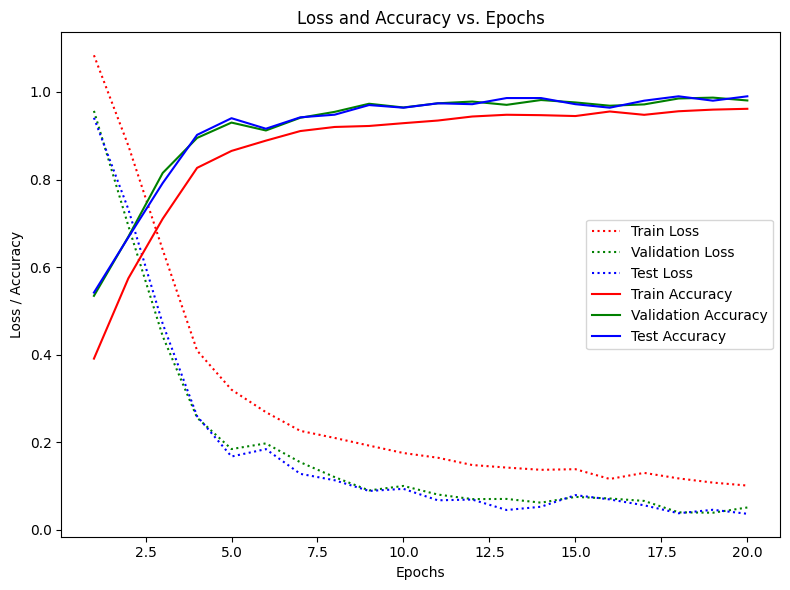

In [15]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False), # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16), # Adjust the batch normalization layer accordingly
    nn.Dropout(0.2),
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

  5%|▌         | 1/20 [00:10<03:26, 10.85s/it]

EPOCH: 01/20 LOSS: 1.0247 ACC: 0.4605  VAL-LOSS: 0.7273 VAL-ACC: 0.6750  TEST-LOSS: 0.7591 TEST-ACC: 0.6640 


 10%|█         | 2/20 [00:21<03:14, 10.82s/it]

EPOCH: 02/20 LOSS: 0.6083 ACC: 0.7363  VAL-LOSS: 0.3880 VAL-ACC: 0.8505  TEST-LOSS: 0.4105 TEST-ACC: 0.8440 


 15%|█▌        | 3/20 [00:32<03:04, 10.86s/it]

EPOCH: 03/20 LOSS: 0.3681 ACC: 0.8521  VAL-LOSS: 0.2690 VAL-ACC: 0.9000  TEST-LOSS: 0.2965 TEST-ACC: 0.8820 


 20%|██        | 4/20 [00:43<02:53, 10.82s/it]

EPOCH: 04/20 LOSS: 0.2570 ACC: 0.9012  VAL-LOSS: 0.1580 VAL-ACC: 0.9470  TEST-LOSS: 0.1507 TEST-ACC: 0.9500 


 25%|██▌       | 5/20 [00:54<02:42, 10.84s/it]

EPOCH: 05/20 LOSS: 0.2071 ACC: 0.9208  VAL-LOSS: 0.1360 VAL-ACC: 0.9490  TEST-LOSS: 0.1233 TEST-ACC: 0.9620 


 30%|███       | 6/20 [01:04<02:31, 10.80s/it]

EPOCH: 06/20 LOSS: 0.1887 ACC: 0.9277  VAL-LOSS: 0.1249 VAL-ACC: 0.9580  TEST-LOSS: 0.1125 TEST-ACC: 0.9640 


 35%|███▌      | 7/20 [01:15<02:20, 10.80s/it]

EPOCH: 07/20 LOSS: 0.1544 ACC: 0.9425  VAL-LOSS: 0.1316 VAL-ACC: 0.9450  TEST-LOSS: 0.1317 TEST-ACC: 0.9500 


 40%|████      | 8/20 [01:26<02:09, 10.77s/it]

EPOCH: 08/20 LOSS: 0.1300 ACC: 0.9516  VAL-LOSS: 0.1334 VAL-ACC: 0.9540  TEST-LOSS: 0.1232 TEST-ACC: 0.9520 


 45%|████▌     | 9/20 [01:37<01:57, 10.72s/it]

EPOCH: 09/20 LOSS: 0.1292 ACC: 0.9532  VAL-LOSS: 0.1246 VAL-ACC: 0.9525  TEST-LOSS: 0.1276 TEST-ACC: 0.9540 


 50%|█████     | 10/20 [01:47<01:46, 10.68s/it]

EPOCH: 10/20 LOSS: 0.1173 ACC: 0.9581  VAL-LOSS: 0.0835 VAL-ACC: 0.9685  TEST-LOSS: 0.0690 TEST-ACC: 0.9720 


 55%|█████▌    | 11/20 [01:58<01:36, 10.76s/it]

EPOCH: 11/20 LOSS: 0.1266 ACC: 0.9524  VAL-LOSS: 0.0552 VAL-ACC: 0.9825  TEST-LOSS: 0.0632 TEST-ACC: 0.9780 


 60%|██████    | 12/20 [02:09<01:25, 10.75s/it]

EPOCH: 12/20 LOSS: 0.1028 ACC: 0.9617  VAL-LOSS: 0.0591 VAL-ACC: 0.9765  TEST-LOSS: 0.0716 TEST-ACC: 0.9760 


 65%|██████▌   | 13/20 [02:20<01:15, 10.79s/it]

EPOCH: 13/20 LOSS: 0.0950 ACC: 0.9644  VAL-LOSS: 0.0542 VAL-ACC: 0.9825  TEST-LOSS: 0.0702 TEST-ACC: 0.9820 


 70%|███████   | 14/20 [02:30<01:04, 10.79s/it]

EPOCH: 14/20 LOSS: 0.0861 ACC: 0.9691  VAL-LOSS: 0.0634 VAL-ACC: 0.9740  TEST-LOSS: 0.0737 TEST-ACC: 0.9740 


 75%|███████▌  | 15/20 [02:41<00:53, 10.74s/it]

EPOCH: 15/20 LOSS: 0.0837 ACC: 0.9701  VAL-LOSS: 0.0681 VAL-ACC: 0.9745  TEST-LOSS: 0.0727 TEST-ACC: 0.9780 


 80%|████████  | 16/20 [02:52<00:42, 10.69s/it]

EPOCH: 16/20 LOSS: 0.0892 ACC: 0.9672  VAL-LOSS: 0.0458 VAL-ACC: 0.9845  TEST-LOSS: 0.0573 TEST-ACC: 0.9780 


 85%|████████▌ | 17/20 [03:02<00:31, 10.66s/it]

EPOCH: 17/20 LOSS: 0.0762 ACC: 0.9715  VAL-LOSS: 0.0400 VAL-ACC: 0.9840  TEST-LOSS: 0.0432 TEST-ACC: 0.9820 


 90%|█████████ | 18/20 [03:13<00:21, 10.74s/it]

EPOCH: 18/20 LOSS: 0.0783 ACC: 0.9704  VAL-LOSS: 0.0520 VAL-ACC: 0.9780  TEST-LOSS: 0.0508 TEST-ACC: 0.9840 


 95%|█████████▌| 19/20 [03:24<00:10, 10.72s/it]

EPOCH: 19/20 LOSS: 0.0684 ACC: 0.9757  VAL-LOSS: 0.0486 VAL-ACC: 0.9840  TEST-LOSS: 0.0405 TEST-ACC: 0.9860 


100%|██████████| 20/20 [03:35<00:00, 10.76s/it]

EPOCH: 20/20 LOSS: 0.0694 ACC: 0.9744  VAL-LOSS: 0.0457 VAL-ACC: 0.9805  TEST-LOSS: 0.0469 TEST-ACC: 0.9720 


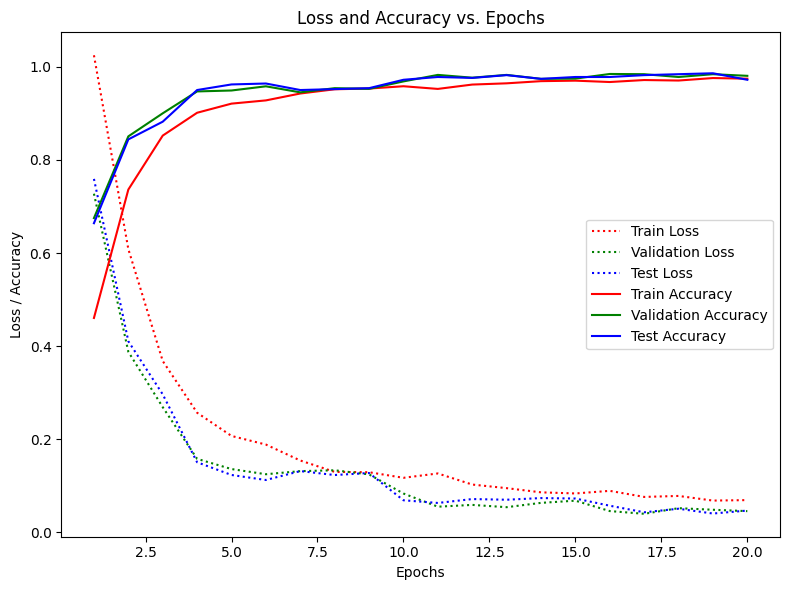

In [16]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
    nn.Linear(100, 3),
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

  5%|▌         | 1/20 [00:11<03:32, 11.20s/it]

EPOCH: 01/20 LOSS: 1.0984 ACC: 0.3619  VAL-LOSS: 1.0592 VAL-ACC: 0.4455  TEST-LOSS: 1.0775 TEST-ACC: 0.3940 


 10%|█         | 2/20 [00:21<03:15, 10.87s/it]

EPOCH: 02/20 LOSS: 1.0133 ACC: 0.4831  VAL-LOSS: 0.9108 VAL-ACC: 0.5765  TEST-LOSS: 0.9501 TEST-ACC: 0.5460 


 15%|█▌        | 3/20 [00:32<03:04, 10.85s/it]

EPOCH: 03/20 LOSS: 0.8354 ACC: 0.6155  VAL-LOSS: 0.7385 VAL-ACC: 0.6725  TEST-LOSS: 0.7552 TEST-ACC: 0.6760 


 20%|██        | 4/20 [00:43<02:53, 10.82s/it]

EPOCH: 04/20 LOSS: 0.6761 ACC: 0.7040  VAL-LOSS: 0.6106 VAL-ACC: 0.7480  TEST-LOSS: 0.6319 TEST-ACC: 0.7160 


 25%|██▌       | 5/20 [00:54<02:41, 10.80s/it]

EPOCH: 05/20 LOSS: 0.5710 ACC: 0.7619  VAL-LOSS: 0.5010 VAL-ACC: 0.7870  TEST-LOSS: 0.4847 TEST-ACC: 0.8120 


 30%|███       | 6/20 [01:04<02:30, 10.77s/it]

EPOCH: 06/20 LOSS: 0.4734 ACC: 0.8057  VAL-LOSS: 0.4449 VAL-ACC: 0.8105  TEST-LOSS: 0.4453 TEST-ACC: 0.8200 


 35%|███▌      | 7/20 [01:15<02:19, 10.72s/it]

EPOCH: 07/20 LOSS: 0.3970 ACC: 0.8424  VAL-LOSS: 0.4137 VAL-ACC: 0.8350  TEST-LOSS: 0.4245 TEST-ACC: 0.8200 


 40%|████      | 8/20 [01:26<02:08, 10.67s/it]

EPOCH: 08/20 LOSS: 0.3453 ACC: 0.8584  VAL-LOSS: 0.3497 VAL-ACC: 0.8640  TEST-LOSS: 0.3522 TEST-ACC: 0.8520 


 45%|████▌     | 9/20 [01:36<01:57, 10.68s/it]

EPOCH: 09/20 LOSS: 0.2992 ACC: 0.8839  VAL-LOSS: 0.3162 VAL-ACC: 0.8790  TEST-LOSS: 0.3407 TEST-ACC: 0.8580 


 50%|█████     | 10/20 [01:47<01:47, 10.77s/it]

EPOCH: 10/20 LOSS: 0.2758 ACC: 0.8923  VAL-LOSS: 0.3056 VAL-ACC: 0.8795  TEST-LOSS: 0.3414 TEST-ACC: 0.8620 


 55%|█████▌    | 11/20 [01:58<01:37, 10.79s/it]

EPOCH: 11/20 LOSS: 0.2461 ACC: 0.9029  VAL-LOSS: 0.2643 VAL-ACC: 0.9000  TEST-LOSS: 0.2816 TEST-ACC: 0.8960 


 60%|██████    | 12/20 [02:09<01:26, 10.81s/it]

EPOCH: 12/20 LOSS: 0.2235 ACC: 0.9164  VAL-LOSS: 0.2366 VAL-ACC: 0.9070  TEST-LOSS: 0.2555 TEST-ACC: 0.9040 


 65%|██████▌   | 13/20 [02:20<01:15, 10.76s/it]

EPOCH: 13/20 LOSS: 0.1973 ACC: 0.9227  VAL-LOSS: 0.2183 VAL-ACC: 0.9175  TEST-LOSS: 0.2474 TEST-ACC: 0.9060 


 70%|███████   | 14/20 [02:30<01:04, 10.75s/it]

EPOCH: 14/20 LOSS: 0.1810 ACC: 0.9308  VAL-LOSS: 0.2213 VAL-ACC: 0.9215  TEST-LOSS: 0.2159 TEST-ACC: 0.9120 


 75%|███████▌  | 15/20 [02:41<00:53, 10.78s/it]

EPOCH: 15/20 LOSS: 0.1744 ACC: 0.9333  VAL-LOSS: 0.2063 VAL-ACC: 0.9245  TEST-LOSS: 0.2059 TEST-ACC: 0.9220 


 80%|████████  | 16/20 [02:52<00:43, 10.78s/it]

EPOCH: 16/20 LOSS: 0.1516 ACC: 0.9444  VAL-LOSS: 0.1918 VAL-ACC: 0.9310  TEST-LOSS: 0.2017 TEST-ACC: 0.9320 


 85%|████████▌ | 17/20 [03:03<00:32, 10.84s/it]

EPOCH: 17/20 LOSS: 0.1388 ACC: 0.9465  VAL-LOSS: 0.1783 VAL-ACC: 0.9325  TEST-LOSS: 0.1750 TEST-ACC: 0.9280 


 90%|█████████ | 18/20 [03:14<00:21, 10.80s/it]

EPOCH: 18/20 LOSS: 0.1365 ACC: 0.9495  VAL-LOSS: 0.1770 VAL-ACC: 0.9380  TEST-LOSS: 0.1876 TEST-ACC: 0.9240 


 95%|█████████▌| 19/20 [03:24<00:10, 10.80s/it]

EPOCH: 19/20 LOSS: 0.1219 ACC: 0.9561  VAL-LOSS: 0.1969 VAL-ACC: 0.9275  TEST-LOSS: 0.2053 TEST-ACC: 0.9280 


100%|██████████| 20/20 [03:35<00:00, 10.79s/it]

EPOCH: 20/20 LOSS: 0.1239 ACC: 0.9527  VAL-LOSS: 0.1700 VAL-ACC: 0.9410  TEST-LOSS: 0.1632 TEST-ACC: 0.9400 


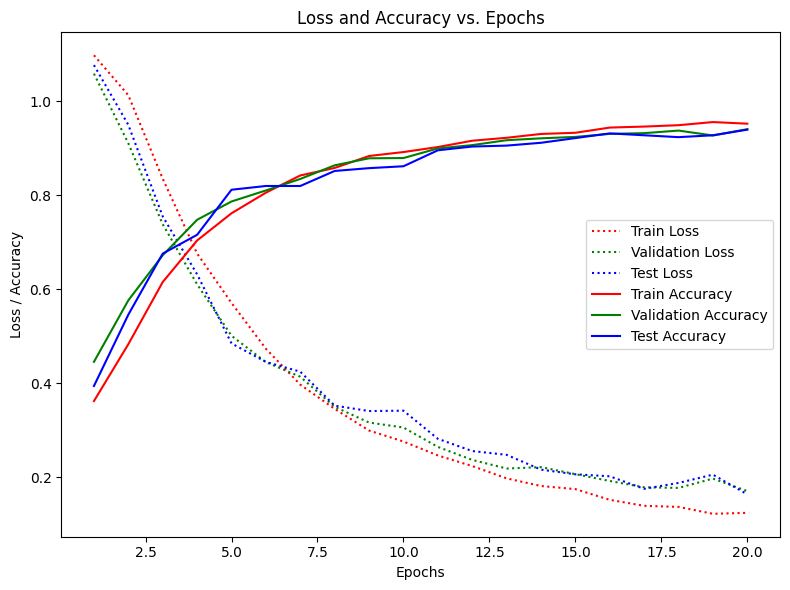

In [17]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [ ]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

In [ ]:
# # function to determine performance of model
# def query_performance(queries, targets, gt, top=1):
#     assert top >= 1
#     cnt = 0
#     for i in range(gt.shape[0]):
#
#         q = queries[i][None].float().cuda()
#         t = targets[i].float().cuda()
#
#         with torch.no_grad():
#
#
#             ### MODIFY IF NECESSARY ###
#             emb_q = net(q).cpu().numpy()
#             emb_t = net(t).cpu().numpy()
#
#             dists = cdist(emb_q, emb_t)
#
#             if top == 1:
#                 pred = np.argmin(dists)
#
#                 if pred == gt[i]:
#                     cnt += 1
#
#             else:
#                 pred = np.argsort(dists)
#                 if gt[i] in pred[0,:top].tolist():
#                     cnt+=1
#     return (100*cnt/gt.shape[0])

In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###

In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import torch
import torch.nn as nn

# Define your model for task 2
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define your model architecture here
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.avgpool = nn.AvgPool2d(4)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Create an instance of the model
net = Model()

# Load the pre-trained weights (if available)
# net.load_state_dict(torch.load('task2_model_weights.pth'))

# Set the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# function to determine performance of model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries[i][None]).float().to(device)
        t = torch.from_numpy(targets[i]).float().to(device)

        with torch.no_grad():
            emb_q = net(q).cpu().numpy()
            emb_t = net(t).cpu().numpy()

            dists = cdist(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

In [ ]:
print(top_1_accuracy)
print(top_3_accuracy)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.spatial.distance import cdist

# Define the model architecture
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(164864, num_classes)  # Adjust the input size based on your data

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

# Function to determine performance of the model
def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0
    for i in range(gt.shape[0]):
        q = queries[i][None].float().to(device)
        t = targets[i].float().to(device)

        with torch.no_grad():
            emb_q = net(q)
            emb_t = net(t)

            dists = cdist(emb_q.cpu().numpy(), emb_t.cpu().numpy())

            if top == 1:
                pred = np.argmin(dists)

                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1
    return (100 * cnt / gt.shape[0])

# Loading training and testing data for Task 2
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(int)
gt = task2['arr_2'].astype(int)  # Ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

# Determine the number of distinct classes in your dataset
num_classes = len(np.unique(y))

# Convert numpy arrays to PyTorch tensors
X = torch.from_numpy(X).float().to(device)
y = torch.from_numpy(y).long().to(device)
gt = torch.from_numpy(gt).long().to(device)
queries = torch.from_numpy(queries).float().to(device)
targets = torch.from_numpy(targets).float().to(device)

# Create an instance of the model
net = Model().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Training loop
num_epochs = 1
batch_size = 32
total_samples = X.shape[0]
num_batches = total_samples // batch_size

for epoch in range(num_epochs):
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        inputs = X[start_idx:end_idx]
        labels = y[start_idx:end_idx]

        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print epoch loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

# Test the performance of the model
top_1_accuracy = query_performance(queries, targets, gt, top=1)
top_3_accuracy = query_performance(queries, targets, gt, top=3)

print(f"Top-1 Accuracy: {top_1_accuracy}%")
print(f"Top-3 Accuracy: {top_3_accuracy}%")
